In [5]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

Según distintos benchmarks (papers, kaggle.com) los **algoritmos de uso general** que tienen más veces la mejor performance son: **Gradient Boosted Trees, Random Forest y SVM**.

In [6]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=2)

In [7]:
from sklearn.model_selection import train_test_split

X = pd.read_csv('./documents/X_opening.csv')
Y = X['worldwide_gross']
X = X.drop('worldwide_gross',axis=1)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

In [9]:
model.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [10]:
import graphviz
from sklearn.tree import export_graphviz

treedot = export_graphviz(model, out_file=None, feature_names=X.columns)

In [11]:
treedot

'digraph Tree {\nnode [shape=box] ;\n0 [label="opening_gross <= 41613376.0\\nmse = 4.491994363696598e+16\\nsamples = 1665\\nvalue = 141540319.054"] ;\n1 [label="opening_gross <= 22074047.0\\nmse = 1.3333822193127832e+16\\nsamples = 1506\\nvalue = 92999937.199"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="mse = 4923666241203542.0\\nsamples = 1257\\nvalue = 64781848.271"] ;\n1 -> 2 ;\n3 [label="mse = 3.147813101998769e+16\\nsamples = 249\\nvalue = 235450289.735"] ;\n1 -> 3 ;\n4 [label="opening_gross <= 70351576.0\\nmse = 1.1039811871593587e+17\\nsamples = 159\\nvalue = 601300162.289"] ;\n0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n5 [label="mse = 4.067538845924502e+16\\nsamples = 92\\nvalue = 440868287.554"] ;\n4 -> 5 ;\n6 [label="mse = 1.2226485798747571e+17\\nsamples = 67\\nvalue = 821594676.851"] ;\n4 -> 6 ;\n}'

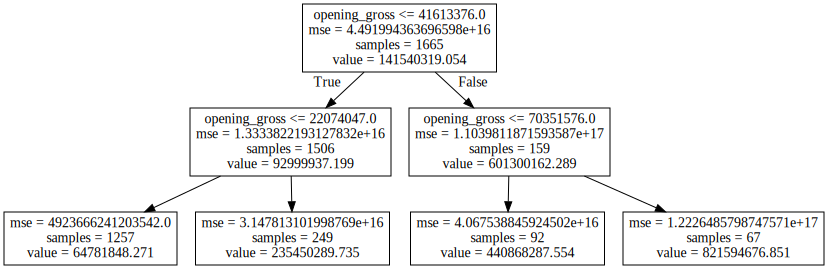

In [12]:
graphviz.Source(treedot)

Virtudes de los arboles de decision:

- Metodo poderoso y probado
- Interpretable
- No necesita escalar los datos (clasificación), y menos preprocesamiento de variables

Sin embargo en la practica existen modelos que obtienen mejor rendimiento. Como mejorar el 
modelo de arboles de decisión?

## Ensembles

### Concepto General

Random Forest y Gradient Boosted Trees, forman parte de una familia de algoritmos que se denominan ensembles.

$$ Ensemble = Submodelos \rightarrow Entrenamiento \rightarrow Predicciones_{Intermedias} \rightarrow Voto \rightarrow Prediccion_{final}$$

### Cómo funciona el algoritmo Random Forest?

Vamos a generar cientos de modelos de arboles de decisión que serán entrenados sobre conjuntos de datos bootstrapeados del conjunto de datos original y donde para cada etapa de separación el conjunto de features elegibles sera un subconjunto aleatorio del conjunto original de features.


Cada uno de los arboles entrenados luego podrá votar por su predicción y promediaremos estos votos.


### Ensembles del pobre ("Poor man's ensembles")

- Entrenar diversos modelos a mano
- Promediar el resultado
- Owen Zhang, número 1 de Kaggle.com durante un largo tiempo, ocupaba esta estrategia promediando diversos modelos XGBoost.
- `from sklearn.ensemble` import VotingClassifier sirve por ejemplo para hacer un ensemble manual de clasificación

En general los ensembles del pobre funcionan ya que cada uno de los modelos que votarán en conjunto son bastante fuertes.

### Porqué RF es poderoso?

**Leo Breiman** creador del Random Forest demostró que un ensemble podía tener buen poder de generalización sí:

1. Los submodelos tienen buen poder de predicción
2. Los submodelos están descorrelacionados

Así el algoritmo de Random Forest compromete un poco de poder de predicción de cada uno de los decision trees que arma, pero la forma aleatoria de generarlos hace que esten fuertemente descorrelacionados.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

forest = RandomForestRegressor(200)
results = cross_validate(forest, X, Y, cv=5, scoring='r2', return_train_score=True)
results

{'fit_time': array([1.4245398 , 1.53550625, 1.67536092, 1.64208841, 1.57106113]),
 'score_time': array([0.01499581, 0.01800585, 0.02399254, 0.01999164, 0.02097988]),
 'test_score': array([0.47153635, 0.69023056, 0.56741918, 0.40851783, 0.44362061]),
 'train_score': array([0.96238476, 0.96835827, 0.96798137, 0.96542855, 0.96456659])}

In [17]:
test_scores = results['test_score']
train_scores = results['train_score']

print(np.mean(train_scores))
print(np.mean(test_scores))

0.9657439095446314
0.5162649050868202


Mejor resultado que Lasso! Ya no tenemos Bias y tenemos un mejor score r2. Sin embargo tenemos una diferencia importante entre score de entrenamiento y de test (overfit).

## Gradient Boosted Trees

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

ensemble = GradientBoostingRegressor()
results = cross_validate(ensemble, X, Y, cv=5, scoring='r2', return_train_score=True)

In [20]:
test_scores = results['test_score']
train_scores = results['train_score']

print(np.mean(train_scores))
print(np.mean(test_scores))

0.9151392143549633
0.5272621433589975


Cómo optimizamos los parametros de este último modelo?

## Optimización de hiperparametros

- Fijar un learning rate alto
- Fijar parametros de los arboles
- Fijados estos parametros, elegir el mejor numero de estimadores que conforman el ensemble
- (Tarea) Con el learning rate dado y el numero de estimadores óptimo, optimizar los parametros de los arboles

### Grid Search

Por ahora dijimos que:

- `train_test_split` servia para evaluaciones rapidas, testeos y prototipaje
- `cross_validate` es un método más robusto para poder estimar el rendimiento de tu algoritmo
Sin embargo una vez que hemos finalizado nuestra etapa de prototipaje y ya queremos establecer un modelo definitivo deberiamos seguir el flujo siguiente.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

In [33]:
from sklearn.model_selection import GridSearchCV

param_test1 = {'n_estimators': range(20, 501, 20)}

In [34]:
list(param_test1['n_estimators'])

[20,
 40,
 60,
 80,
 100,
 120,
 140,
 160,
 180,
 200,
 220,
 240,
 260,
 280,
 300,
 320,
 340,
 360,
 380,
 400,
 420,
 440,
 460,
 480,
 500]

In [35]:
estimator = GradientBoostingRegressor(learning_rate=0.1,
                                    min_samples_split=500,
                                    min_samples_leaf=50,
                                    max_depth=8,
                                    max_features='sqrt',
                                    subsample=0.8,
                                    random_state=10)

In [36]:
gsearch1 = GridSearchCV(estimator, param_grid=param_test1, scoring='r2', cv=5, return_train_score=True)

In [37]:
gsearch1.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=8,
                                                 max_features='sqrt',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=50,
                                                 min_samples_split=500,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
           

In [38]:
list(zip(gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['std_test_score'], gsearch1.cv_results_['params']))

[(0.6553377167287445, 0.057637232303888744, {'n_estimators': 20}),
 (0.7194707183052497, 0.06255974658122894, {'n_estimators': 40}),
 (0.7347239263041044, 0.06359927761595936, {'n_estimators': 60}),
 (0.7389339055742862, 0.062364772765764395, {'n_estimators': 80}),
 (0.7420485206288182, 0.06271425977283827, {'n_estimators': 100}),
 (0.7459322395926498, 0.06235500960463639, {'n_estimators': 120}),
 (0.7495406754127887, 0.06335029572288614, {'n_estimators': 140}),
 (0.7508197586274828, 0.0630468837559907, {'n_estimators': 160}),
 (0.7525654539309128, 0.0634404813604329, {'n_estimators': 180}),
 (0.753490598609423, 0.06446653281824148, {'n_estimators': 200}),
 (0.7545692717605134, 0.06341510679393178, {'n_estimators': 220}),
 (0.7553059694284987, 0.06488882352873111, {'n_estimators': 240}),
 (0.7551714860288669, 0.06572082397934953, {'n_estimators': 260}),
 (0.753885223323653, 0.06495415209551622, {'n_estimators': 280}),
 (0.7546023133872946, 0.06568746888772704, {'n_estimators': 300}),
 

In [41]:
final_results = cross_validate(gsearch1.best_estimator_, X_train, Y_train, return_train_score=True)

In [42]:
test_scores = final_results['test_score']
train_scores = final_results['train_score']

print(np.mean(train_scores))
print(np.mean(test_scores))

0.8183169366503803
0.74138761251573


In [43]:
estimator = GradientBoostingRegressor(learning_rate=0.1,
                                     min_samples_split=500,
                                     min_samples_leaf=50,
                                     max_depth=8,
                                     max_features='sqrt',
                                     subsample=0.8,
                                     random_state=10,
                                     n_estimators=240)

In [44]:
estimator.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=8,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=500,
                          min_weight_fraction_leaf=0.0, n_estimators=240,
                          n_iter_no_change=None, presort='auto',
                          random_state=10, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
estimator.score(X_test, Y_test)

0.8092888852563106

## Reflexiones de cierre

### Recursos

- Reddit /machinelearning y /learnmachinelearning
- Analytics Vidhya y KD Nuggets
- Kaggle.com y "There is no Free Hunch" Blog
- Arxiv, papers
- Libros: "Pattern Recognition and Machine Learning" C.Bishop y "Elements of Statistical Learning".

### Próximos pasos

Matemáticas
- Praxis: Feature Engineering, Model Selection y Tuning
- Deep Learning para NLP y Computer Vision
- Machine Learning Bayesiano